Notebook that performs a sanity check in which we split the TDC group into two halves, and these are used to calculate pseudo R2 maps. Such maps are associated with the transcriptomics data later. In this way, we can test whether ASD genes and enrichments are different from those in the TDC group

In [1]:
#IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

from os.path import join as opj
from scipy.io import savemat, loadmat
import os
import pickle
from scipy.stats import pearsonr, ttest_ind, kruskal, levene
from scipy.spatial.distance import squareform, pdist
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import LabelEncoder

In [2]:
data_dir = "../data"
results_dir = "../results/desikan"

In [3]:
groups = np.load(opj(results_dir, 'data_after_combat_motion_aggressive.npz'))['group']
subjects = np.load(opj(results_dir,'data_after_combat_motion_aggressive.npz'))['subjects'][groups==2]
Y_tdc_combat = np.load(opj(results_dir, 'data_after_combat_motion_aggressive.npz'))['Y_combat'][groups==2]
CC_tdc_combat = np.load(opj(results_dir, 'data_after_combat_motion_aggressive.npz'))['CC_combat'][groups==2]
age = np.load(opj(results_dir, 'data_after_combat_motion_aggressive.npz'))['age'][groups==2]
sex = np.load(opj(results_dir, 'data_after_combat_motion_aggressive.npz'))['sex'][groups==2]
motion = np.load(opj(results_dir, 'data_after_combat_motion_aggressive.npz'))['motion'][groups==2]

# overall connectivity
glob_conn = np.apply_along_axis(lambda x: np.mean(x[x>0]), axis=1, arr=Y_tdc_combat)

# Load demo data
demo = pd.read_excel(opj(results_dir, "pheno_w_clusters.xlsx"))
demo_merged = pd.merge(pd.DataFrame({'SUB_ID': subjects}), demo, on='SUB_ID')
del demo

fiq = demo_merged.FIQ.to_numpy()

## 1- Split data into 2 halves

In [4]:
from sklearn.model_selection import train_test_split
from scipy.stats import ks_2samp, fisher_exact

alpha=0.5
idxs = np.arange(len(subjects))

seeds, selected_p_vals = [], []
for ii in tqdm.tqdm(range(1000)):
    idxs_1, idxs_2 = train_test_split(idxs, test_size=0.5, random_state=ii)

    _, p_age = ks_2samp(age[idxs_1], age[idxs_2])
    _, p_sex = fisher_exact([np.unique(sex[idxs_1], return_counts=True)[1],
                             np.unique(sex[idxs_2], return_counts=True)[1]])
    
    _, p_motion_fd = ks_2samp(motion[idxs_1,0], motion[idxs_2,0])
    _, p_motion_dvars = ks_2samp(motion[idxs_1,1], motion[idxs_2,1])

    _, p_conn = ks_2samp(glob_conn[idxs_1], glob_conn[idxs_2])
    
    _, p_fiq = ks_2samp(fiq[idxs_1][~np.isnan(fiq[idxs_1])], 
                        fiq[idxs_2][~np.isnan(fiq[idxs_2])])

    p_vals = np.array([p_age, p_sex, p_motion_fd, p_motion_dvars, p_conn, p_fiq])
    cond = np.all(p_vals > alpha)

    if cond:
        seeds.append(ii)
        selected_p_vals.append(p_vals)

selected_p_vals = np.array(selected_p_vals)
seeds = np.array(seeds)

100%|██████████| 1000/1000 [00:12<00:00, 80.77it/s]


In [5]:
final_seed = seeds[np.argmax(selected_p_vals[:,0])] # the seed with the largest p-value w.r.t group diffs
idxs_1, idxs_2 = train_test_split(idxs, test_size=0.5, random_state=final_seed)

age_1, age_2 = age[idxs_1], age[idxs_2]
ks, p = ks_2samp(age_1, age_2)
print("Age 1 = %f, Age 2= %f, ks = %.3f, p=%.3f" % (age[idxs_1].mean(), age[idxs_2].mean(), ks, p))
print("")

sex_1, sex_2 = sex[idxs_1], sex[idxs_2]
table = [np.unique(sex_1, return_counts=True)[1],np.unique(sex_2, return_counts=True)[1]]
oddsr, p = fisher_exact(table)
print("Sex table ", table, "OR = %.3f, p=%.3f" % (oddsr, p))
print("")

fd_1, fd_2 = motion[idxs_1,0], motion[idxs_2,0]
ks, p = ks_2samp(fd_1,fd_2)
print("FD 1 = %f, FD 2= %f, ks = %.3f, p=%.3f" % (motion[idxs_1,0].mean(), motion[idxs_2,0].mean(), ks, p))
print("")

dvars_1, dvars_2 = motion[idxs_1,1],motion[idxs_2,1]
ks, p = ks_2samp(dvars_1, dvars_2)
print("DVARS 1 = %f, DVARS 2= %f, ks = %.3f, p=%.3f" % (motion[idxs_1,1].mean(), motion[idxs_2,1].mean(), ks, p))
print("")
glob_conn_1, glob_conn_2 = glob_conn[idxs_1],  glob_conn[idxs_2]
ks, p = ks_2samp(glob_conn_1, glob_conn_2)
print("Global conn 1 = %f, Global conn 2= %f, ks = %.3f, p=%.3f" % (glob_conn_1.mean(), 
                                                    glob_conn_2.mean(), 
                                                    ks, p))
print("")
fiq_1, fiq_2 = fiq[idxs_1],  fiq[idxs_2]
ks, p = ks_2samp(fiq_1[~np.isnan(fiq_1)], fiq_2[~np.isnan(fiq_2)])
print("FIQ 1 = %f, FIQ 2= %f, ks = %.3f, p=%.3f" % (fiq_1[~np.isnan(fiq_1)].mean(), 
                                                    fiq_2[~np.isnan(fiq_2)].mean(), 
                                                    ks, p))

Age 1 = 16.277450, Age 2= 16.215170, ks = 0.032, p=0.980

Sex table  [array([335, 107]), array([337, 105])] OR = 0.975, p=0.937

FD 1 = 0.134586, FD 2= 0.135313, ks = 0.036, p=0.935

DVARS 1 = 27.577933, DVARS 2= 27.284037, ks = 0.045, p=0.757

Global conn 1 = 0.399358, Global conn 2= 0.394374, ks = 0.048, p=0.701

FIQ 1 = 113.187050, FIQ 2= 113.755981, ks = 0.032, p=0.972


Separate (harmonised) data for both halves

In [6]:
Y_1, Y_2 = Y_tdc_combat[idxs_1], Y_tdc_combat[idxs_2]
CC_1, CC_2 = CC_tdc_combat[idxs_1], CC_tdc_combat[idxs_2]
subjects_1, subjects_2 = subjects[idxs_1], subjects[idxs_2]

## 2- Denoise one of the halves, which is going to be used for subtyping

In [7]:
from sklearn.linear_model import LinearRegression

n_rois = 82

C = np.column_stack((sex_1, age_1, fd_1, dvars_1))
linReg = LinearRegression()
linReg.fit(C, Y_1)
Y_1_denoised = Y_1 - C.dot(linReg.coef_.T)

CC_1_denoised = np.array([squareform(Y_1_denoised[ii, :]) + np.identity(n_rois) 
                          for ii in range(len(subjects_1))])

Save denoised data of half 1 for subtyping

In [8]:
savemat(opj(results_dir, "consensus_data_tdc_split_sanity_check.mat"), 
        {'CC_1_denoised': CC_1_denoised, 'subjects_1': subjects_1, 'idxs_1': idxs_1} 
       )

# RUN consensus in MATLAB...

## 3- Compute pseudo R2 comparing subtypes with the other half

In [9]:
from mdmr import MDMR

In [10]:
S_tdc = loadmat(opj(results_dir, "results_clustering_tdc_partition_k_0220.mat"),
        struct_as_record=False, 
        squeeze_me=True)['res_cluster_euclidean'].S

In [11]:
np.unique(S_tdc, return_counts=True)

(array([1, 2, 3], dtype=uint8), array([246, 181,  15]))

In [12]:
clus_idx1 = np.where(S_tdc==1)[0]
clus_idx2 = np.where(S_tdc==2)[0]

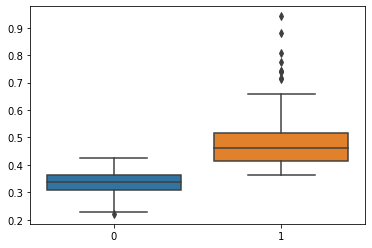

In [13]:
sns.boxplot(data=[[glob_conn_1[clus_idx1]], [glob_conn_1[clus_idx2]]])
pass

So as we can see, we again obtain two subtypes, hypo and hiper. This is all due to being using euclidean distances when clustering.

(Harmonised) Connectivity matrices of both subtypes

In [14]:
CC_11 = CC_1[clus_idx1]
CC_12 = CC_1[clus_idx2]

Are there statistical differences in age, sex and motion between subtypes? There should not be, if denoising worked

In [15]:
var = age_1
a, b = var[clus_idx1], var[clus_idx2]
ks, p = ks_2samp(a, b)
print("Age: ", ks, p)
print("")

var = sex_1
a, b = var[clus_idx1], var[clus_idx2]
table = [np.unique(a, return_counts=True)[1],np.unique(b, return_counts=True)[1]]
oddsr, p = fisher_exact(table)
print("Sex table ", table, "OR = %.3f, p=%.3f" % (oddsr, p))
print("")

var = fd_1
a, b = var[clus_idx1], var[clus_idx2]
ks, p = ks_2samp(a, b)
print("FD: ", ks, p)
print("")


var = dvars_1
a, b = var[clus_idx1], var[clus_idx2]
ks, p = ks_2samp(a, b)
print("DVARS: ", ks, p)
print("")

Age:  0.10086241746395365 0.2196283755108257

Sex table  [array([186,  60]), array([138,  43])] OR = 0.966, p=0.909

FD:  0.10733054844360598 0.16494813794121077

DVARS:  0.06102052733234515 0.8024465489247424



Empty dataframes where to insert R2

In [16]:
res_F_df_euclidean = pd.DataFrame({})
res_Rsq_df_euclidean = pd.DataFrame({})

In [17]:
clus_idx = clus_idx1

YY = np.row_stack((CC_1[clus_idx], CC_2))
X_df = pd.DataFrame({
    'group': ['clus_1']*len(clus_idx) + ['group2']*len(subjects_2),
    'age': np.concatenate((age_1[clus_idx], age_2)),
    'sex': np.concatenate((sex_1.flatten()[clus_idx], sex_2.flatten())).astype(str),
    'fiq':np.concatenate((fiq_1[clus_idx], fiq_2)),
    'fd':np.concatenate((fd_1[clus_idx], fd_2)),
    'dvars':np.concatenate((dvars_1[clus_idx], dvars_2))
})

to_take = ~np.any(X_df.isna(), axis=1).values

YY = YY[to_take]
X_df = X_df.loc[to_take, :]

print("doing cluster 1")
list_Fs = []
list_Rs = []

for ii in tqdm.tqdm(range(YY.shape[1])):
    mask = np.arange(n_rois)!=ii

    D = squareform(pdist(YY[:, ii, :][:, mask], 'euclidean'))
    mdmr = MDMR(verbose=0)
    mdmr.fit(X_df, D)
    
    list_Fs.append(mdmr.F_[0])
    list_Rs.append(mdmr.r2_[0])

res_F_df_euclidean['clus_1'] = list_Fs
res_Rsq_df_euclidean['clus_1'] = list_Rs

doing cluster 1


100%|██████████| 82/82 [00:05<00:00, 15.66it/s]


In [18]:
clus_idx = clus_idx2

YY = np.row_stack((CC_1[clus_idx], CC_2))
X_df = pd.DataFrame({
    'group': ['clus_1']*len(clus_idx) + ['group2']*len(subjects_2),
    'age': np.concatenate((age_1[clus_idx], age_2)),
    'sex': np.concatenate((sex_1.flatten()[clus_idx], sex_2.flatten())).astype(str),
    'fiq':np.concatenate((fiq_1[clus_idx], fiq_2)),
    'fd':np.concatenate((fd_1[clus_idx], fd_2)),
    'dvars':np.concatenate((dvars_1[clus_idx], dvars_2))
})

to_take = ~np.any(X_df.isna(), axis=1).values

YY = YY[to_take]
X_df = X_df.loc[to_take, :]

print("doing cluster 2")
list_Fs = []
list_Rs = []

for ii in tqdm.tqdm(range(YY.shape[1])):
    mask = np.arange(n_rois)!=ii

    D = squareform(pdist(YY[:, ii, :][:, mask], 'euclidean'))
    mdmr = MDMR(verbose=0)
    mdmr.fit(X_df, D)
    
    list_Fs.append(mdmr.F_[0])
    list_Rs.append(mdmr.r2_[0])

res_F_df_euclidean['clus_2'] = list_Fs
res_Rsq_df_euclidean['clus_2'] = list_Rs

doing cluster 2


100%|██████████| 82/82 [00:04<00:00, 19.92it/s]


Save to disk to associate with transcriptomics data

In [19]:
res_Rsq_df_euclidean.to_csv(opj(results_dir, "mdmr_rsquare_tdc_split.csv"), index=False)

A quickly visulatisation of these maps...

In [20]:
from nilearn import image, plotting
from nilearn.datasets import load_mni152_template
from nilearn.image import resample_to_img

atlas_img = image.load_img(opj(data_dir, "Desikan_genetics_1mm.nii.gz"))
atlas_img = image.index_img(atlas_img, 0)

# Resample atlas in template. This is just for visualization in this notebook
template_img = load_mni152_template(resolution=1)
atlas_img = resample_to_img(atlas_img, template_img, interpolation='nearest')

/home/javi/anaconda3/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [21]:
def map_onto_brain(stat, atlas):
    from nilearn import image
    
    atlas_data = np.squeeze(image.load_img(atlas).get_fdata())
    rois = np.unique(atlas_data)[1:]
    assert len(stat)==len(rois)
    stat_atlas = np.zeros_like(atlas_data)
    for ii, st in zip(rois, stat):
        stat_atlas[atlas_data==ii] = st
    
    return image.new_img_like(atlas, stat_atlas)

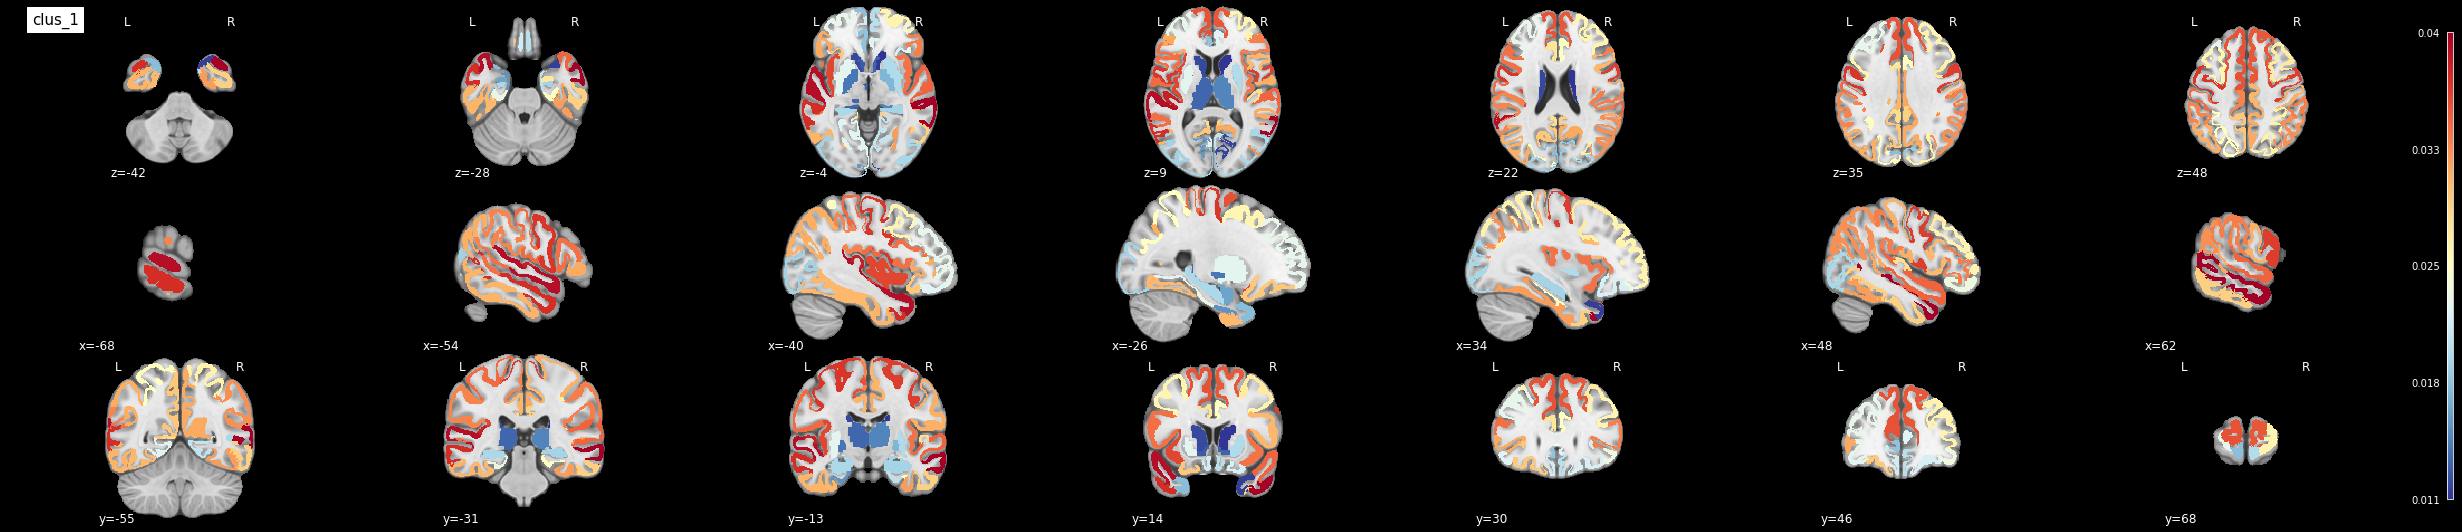

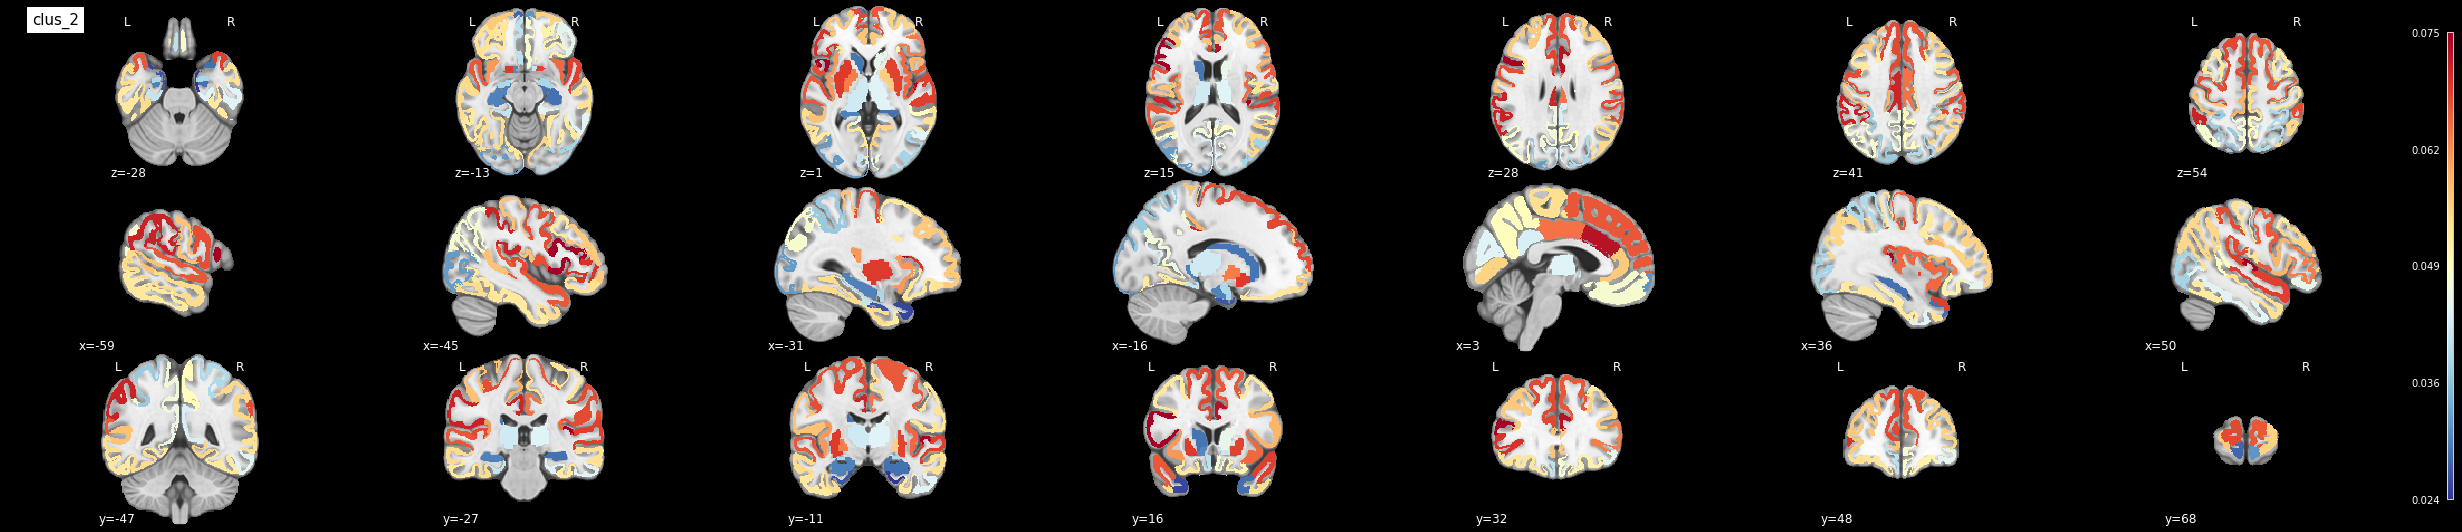

In [22]:
%matplotlib inline

stat_img = map_onto_brain(res_Rsq_df_euclidean.iloc[:, 0], atlas_img)
plotting.plot_img(stat_img, 
                  colorbar=True,
                  threshold=1e-6,
                  display_mode="mosaic",
                  cmap=plt.cm.RdYlBu_r,
                  bg_img = template_img,
                  draw_cross=False, 
                  black_bg=True,
                  title=res_Rsq_df_euclidean.columns[0])

stat_img = map_onto_brain(res_Rsq_df_euclidean.iloc[:, 1], atlas_img)
plotting.plot_img(stat_img, 
                  colorbar=True,
                  threshold=1e-6,
                  display_mode="mosaic",
                  cmap=plt.cm.RdYlBu_r,
                  bg_img = template_img,
                  draw_cross=False, 
                  black_bg=True,
                  title=res_Rsq_df_euclidean.columns[1])
pass

## R1: compare TDC subtypes with ASD subtypes

In [23]:
S_tdc = loadmat(opj(results_dir, "results_clustering_tdc_partition_k_0220.mat"),
        struct_as_record=False, 
        squeeze_me=True)['res_cluster_euclidean'].S

S_asd = loadmat(opj(results_dir, "results_clustering_motion_aggressive_k_0220.mat"),
        struct_as_record=False, 
        squeeze_me=True)['res_cluster_euclidean'].S

In [24]:
groups = np.load(opj("../results/desikan", "data_after_combat_motion_aggressive.npz"))['group']
subjects = np.load(opj("../results/desikan", "data_after_combat_motion_aggressive.npz"))['subjects']
Y_combat = np.load(opj("../results/desikan", 'data_after_combat_motion_aggressive.npz'))['Y_combat']
CC_combat = np.load(opj("../results/desikan", 'data_after_combat_motion_aggressive.npz'))['CC_combat']
age = np.load(opj("../results/desikan", 'data_after_combat_motion_aggressive.npz'))['age']
sex = np.load(opj("../results/desikan", 'data_after_combat_motion_aggressive.npz'))['sex']
motion = np.load(opj("../results/desikan", 'data_after_combat_motion_aggressive.npz'))['motion']

In [25]:
subjects_asd_1 = subjects[groups==1][S_asd==1]
subjects_asd_2 = subjects[groups==1][S_asd==2]

subjects_tdc_1 = subjects_1[S_tdc==1]
subjects_tdc_2 = subjects_1[S_tdc==2]

let's see who is hyper e hypo... 

In [26]:
asd_subj_type = {}
if Y_combat[np.isin(subjects, subjects_asd_1),:].mean(1).mean() > Y_combat[np.isin(subjects, subjects_asd_2),:].mean(1).mean():
    asd_subj_type['hyper'] = subjects_asd_1
    asd_subj_type['hypo'] = subjects_asd_2
else:
    asd_subj_type['hyper'] = subjects_asd_2
    asd_subj_type['hypo'] = subjects_asd_1
    
tdc_subj_type = {}
if Y_combat[np.isin(subjects, subjects_tdc_1),:].mean(1).mean() > Y_combat[np.isin(subjects, subjects_tdc_2),:].mean(1).mean():
    tdc_subj_type['hyper'] = subjects_tdc_1
    tdc_subj_type['hypo'] = subjects_tdc_2
else:
    tdc_subj_type['hyper'] = subjects_tdc_2
    tdc_subj_type['hypo'] = subjects_tdc_1

In [27]:
len(tdc_subj_type['hyper'])

181

In [28]:
print(Y_combat[np.isin(subjects, asd_subj_type['hyper']),:].mean(1).mean())
print(Y_combat[np.isin(subjects, asd_subj_type['hypo']),:].mean(1).mean())

print(Y_combat[np.isin(subjects, tdc_subj_type['hyper']),:].mean(1).mean())
print(Y_combat[np.isin(subjects, tdc_subj_type['hypo']),:].mean(1).mean())

0.404679621401067
0.22512273378912082
0.45264992859017283
0.25181632493428024


In [29]:
Y_hyper_both = np.row_stack((Y_combat[np.isin(subjects, tdc_subj_type['hyper']),:], 
                             Y_combat[np.isin(subjects, asd_subj_type['hyper']),:]))
age_hyper_both = np.concatenate((age[np.isin(subjects, tdc_subj_type['hyper'])], 
                                 age[np.isin(subjects, asd_subj_type['hyper'])]))
sex_hyper_both =  np.concatenate((sex[np.isin(subjects, tdc_subj_type['hyper'])], 
                                 sex[np.isin(subjects, asd_subj_type['hyper'])]))

motion_hyper_both = np.row_stack((motion[np.isin(subjects, tdc_subj_type['hyper']),:], 
                                  motion[np.isin(subjects, asd_subj_type['hyper']),:]))

X_hyper = pd.DataFrame({'group':['TDC']*len(tdc_subj_type['hyper']) + ['ASD']*len(asd_subj_type['hyper']),
                        'sex': age_hyper_both,
                        'age_both':sex_hyper_both,
                        'FD_mean': motion_hyper_both[:,0],
                        'DVARS_mean': motion_hyper_both[:,1]})

Y_hypo_both = np.row_stack((Y_combat[np.isin(subjects, tdc_subj_type['hypo']),:], 
                             Y_combat[np.isin(subjects, asd_subj_type['hypo']),:]))
age_hypo_both = np.concatenate((age[np.isin(subjects, tdc_subj_type['hypo'])], 
                                 age[np.isin(subjects, asd_subj_type['hypo'])]))
sex_hypo_both =  np.concatenate((sex[np.isin(subjects, tdc_subj_type['hypo'])], 
                                 sex[np.isin(subjects, asd_subj_type['hypo'])]))

motion_hypo_both = np.row_stack((motion[np.isin(subjects, tdc_subj_type['hypo']),:], 
                                  motion[np.isin(subjects, asd_subj_type['hypo']),:]))

X_hypo = pd.DataFrame({'group':['TDC']*len(tdc_subj_type['hypo']) + ['ASD']*len(asd_subj_type['hypo']),
                        'sex': age_hypo_both,
                        'age_both':sex_hypo_both,
                        'FD_mean': motion_hypo_both[:,0],
                        'DVARS_mean': motion_hypo_both[:,1]})

In [30]:
import pandas as pd
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
ro.numpy2ri.activate() 
R = ro.r
R('library(MDMR)')

D = squareform(pdist(Y_hyper_both, 'euclidean'))
with localconverter(ro.default_converter + pandas2ri.converter):
    r_from_pd_df = ro.conversion.py2rpy(X_hyper)
    
R.assign('r_from_pd_df', r_from_pd_df)
R('Xm <- model.matrix(~., data=r_from_pd_df)')
R.assign('D', D)    
R('mdmr(Xm, D, perm.p=FALSE)$pv')

R[write to console]: Registered S3 methods overwritten by 'lme4':
  method                          from
  cooks.distance.influence.merMod car 
  influence.merMod                car 
  dfbeta.influence.merMod         car 
  dfbetas.influence.merMod        car 

/home/javi/anaconda3/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:55: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


rec.array([(0.00000000e+00,), (1.33956402e-10,), (3.88527209e-02,),
           (8.55493487e-02,), (0.00000000e+00,), (5.35102154e-01,)],
          dtype=[('analytic.pvals', '<f8')])

In [31]:
import pandas as pd
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
ro.numpy2ri.activate() 
R = ro.r
R('library(MDMR)')

D = squareform(pdist(Y_hypo_both, 'euclidean'))
with localconverter(ro.default_converter + pandas2ri.converter):
    r_from_pd_df = ro.conversion.py2rpy(X_hypo)
    
R.assign('r_from_pd_df', r_from_pd_df)
R('Xm <- model.matrix(~., data=r_from_pd_df)')
R.assign('D', D)    
R('mdmr(Xm, D, perm.p=FALSE)$pv')

rec.array([(0.00000000e+00,), (6.37490061e-13,), (1.43225251e-03,),
           (6.52150882e-01,), (0.00000000e+00,), (7.97314873e-06,)],
          dtype=[('analytic.pvals', '<f8')])